1. Replace empty strings with NaN - DONE
2. Remove the footnotes from the 'Other Source Deaths' column - DONE but revisit row 1238?
3. Convert Magnitude to a numeric - DONE
4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
5. Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

- Are there factors that make an earthquake more likely? 
- Are there factors that make an earthquake more deadly? 
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake? 
- Where would you avoid living?

In [151]:
import numpy as np
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import matplotlib.pyplot as plt
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import seaborn as sns
#hv.notebook_extension('bokeh')
import matplotlib as mpl
mpl.rcParams.update({'font.size': 18})
sns.set(context='notebook',rc={'figure.figsize':(15,8)})
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 10000)
%matplotlib inline

In [152]:
# create a Request object for the wikipedia page for the list of deadly earthquakes since 1900
response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')

# read the resulting HTML into a variable called result_text
result_text = response.text

In [153]:
result_text;

In [154]:
# create the soup by constructing a BS object from the html page and the appropriate parser
soup = BS(result_text, 'html.parser')

In [155]:
soup.title

<title>List of deadly earthquakes since 1900 - Wikipedia</title>

In [156]:
#print(soup.prettify())

In [157]:
table = soup.find_all('table',{'class':'sortable wikitable'})

In [158]:
df = pd.read_html(str(table))

In [159]:
df = df[0]

In [160]:
df.rename(columns=df.iloc[0],inplace=True)
df.rename(columns={'Origin (UTC)':'TimeUTC', 'Present-day country and link to Wikipedia article':'Country'}, inplace=True)

In [161]:
df.drop([0],inplace=True)

In [162]:
df['Other Source Deaths'] = df['Other Source Deaths'].str.split(' ', expand=True)
df['Other Source Deaths'] = df['Other Source Deaths'].str.split('[', expand=True)
df['Other Source Deaths'] = df['Other Source Deaths'].str.split('(', expand=True)
df['Other Source Deaths'] = df['Other Source Deaths'].str.split('+', expand=True)
df['Other Source Deaths'] = df['Other Source Deaths'].str.split('*', expand=True)
df.drop(df.loc[df['Lat']=='?'].index, inplace=True)

In [163]:
df.replace('', np.nan, inplace=True)
df.dropna(subset=['Lat', 'Long'], inplace=True)

In [164]:
df['Magnitude'], df['Units'] = df['Magnitude'].str.split(' ', 1).str
df['Year'] = df.TimeUTC.astype(str).str[:4]
df['Year'] = pd.to_numeric(df['Year'])

In [165]:
df.Country = df.Country.str.split('(', 1).str[0]
df.Country = df.Country.str.strip()

In [166]:
df['Long'] = pd.to_numeric(df['Long'], errors='coerce')
df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')
df['Depth (km)'] = pd.to_numeric(df['Depth (km)'], errors='coerce')
df['PDE Shaking Deaths'] = df['PDE Shaking Deaths'].astype(str).str.replace(',','')
df['PDE Shaking Deaths'] = pd.to_numeric(df['PDE Shaking Deaths'], errors='coerce')
df['PDE Total Deaths'] = df['PDE Total Deaths'].astype(str).str.replace(',','')
df['PDE Total Deaths'] = pd.to_numeric(df['PDE Total Deaths'], errors='coerce')
df['Utsu Total Deaths'] = df['Utsu Total Deaths'].astype(str).str.replace(',','')
df['Utsu Total Deaths'] = pd.to_numeric(df['Utsu Total Deaths'], errors='coerce')
df['EM-DAT Total Deaths'] = df['EM-DAT Total Deaths'].astype(str).str.replace(',','')
df['EM-DAT Total Deaths'] = pd.to_numeric(df['EM-DAT Total Deaths'], errors='coerce')
df['Other Source Deaths'] = df['Other Source Deaths'].astype(str).str.replace(',','')
df['Other Source Deaths'] = pd.to_numeric(df['Other Source Deaths'], errors='coerce')

In [167]:
df['Deaths'] = df.filter(regex='Deaths').apply(np.nanmax, axis=1)
df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')

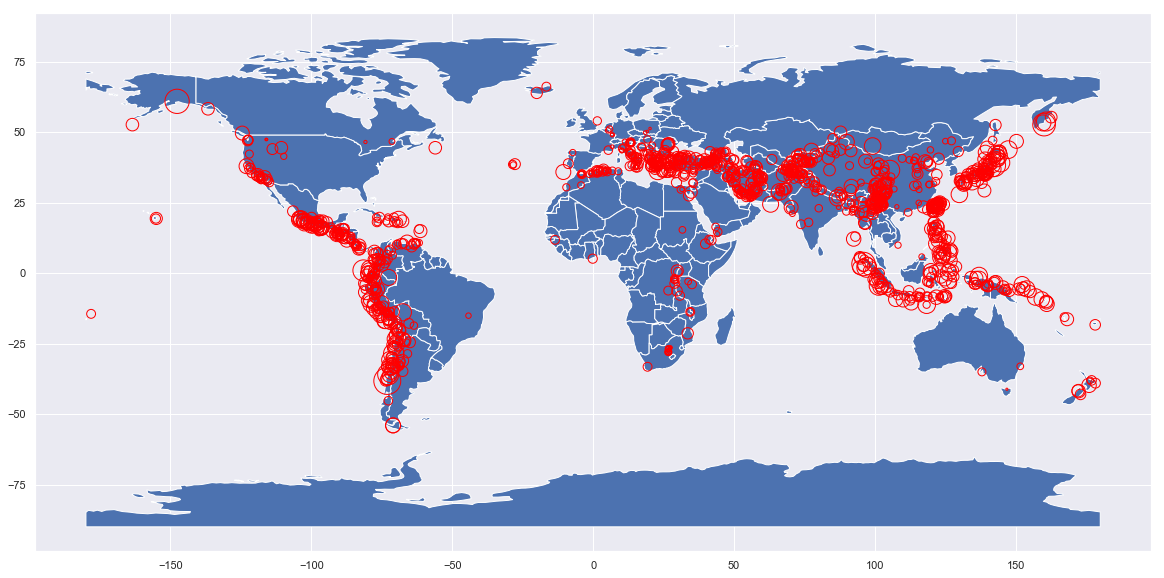

In [168]:
geometry = [Point(xy) for xy in zip(df.Long.astype('float64'), df.Lat.astype('float64'))]
tempdf = df.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(tempdf, crs=crs, geometry=geometry)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,15));
gdf.plot(ax=ax,marker='o',facecolor='None',edgecolor='red',markersize=2.0**df.Magnitude.astype('float64'));

In [169]:
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
width, height = 310,110
popups, locations = [], []

map1 = folium.Map([-15.783333, -47.866667], zoom_start=2, tiles='cartodbpositron')
count = 0
for row in df.iterrows():
    row_values = row[1] 
    locations.append([row_values['Lat'], row_values['Long']])
    #print(count,[row_values['Lat'], row_values['Long']])
    country = row_values['Country'] #.encode('ascii', 'xmlcharrefreplace')
    magnitude = row_values['Magnitude']
    popup = (str(row_values['Country']) + '<br/>' + 
        'Year: ' + str(row_values['Year']) + '<br/>' +
        'Magnitude: ' + str(row_values['Magnitude']) + '<br/>' +
        'Deaths: ' + str(row_values['Deaths'])).replace("'", "`")
    #marker = folium.Marker(location = location, popup = popup)
    #marker.add_to(map1)
    #iframe = IFrame(table('Earthquakes', country, magnitude), width=width, height=height)
    popups.append(popup)
    t = folium.FeatureGroup(name='Earthquakes')
    count += 1

t.add_child(MarkerCluster(locations=locations, popups=popups))
map1.add_child(t)
map1.add_child(folium.LayerControl())
map1

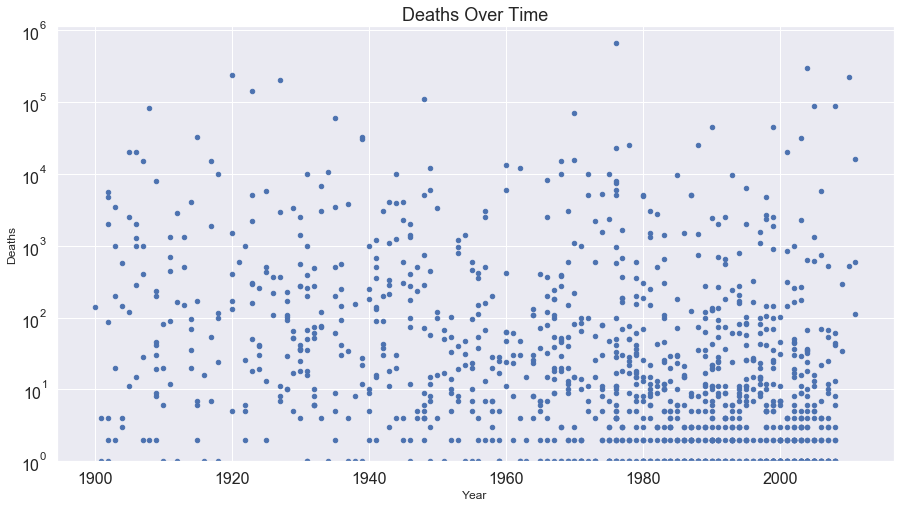

In [170]:
df.plot(kind='scatter',x='Year',y='Deaths',figsize=(15,8),fontsize=16, marker='o')
plt.semilogy()
plt.ylim(bottom=1)
plt.title('Deaths Over Time',fontsize=18);

Text(0.5,1,'Deaths as a Function fo Magnitude')

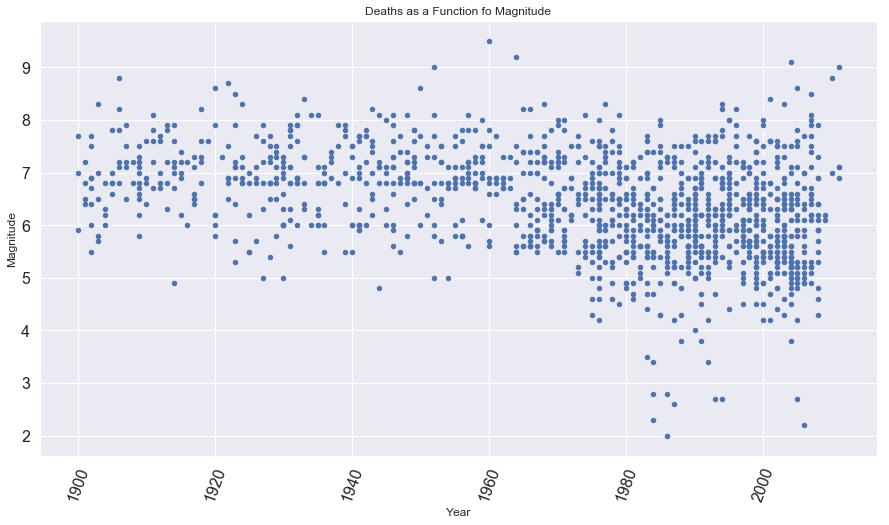

In [171]:
#plt.figure(figsize=(15,8))
df.plot(kind='scatter',x='Year',y='Magnitude',figsize=(15,8),fontsize=16);
#plt.locator_params(axis='x', numticks=4)
plt.xticks(rotation=70);
plt.title('Deaths as a Function fo Magnitude')

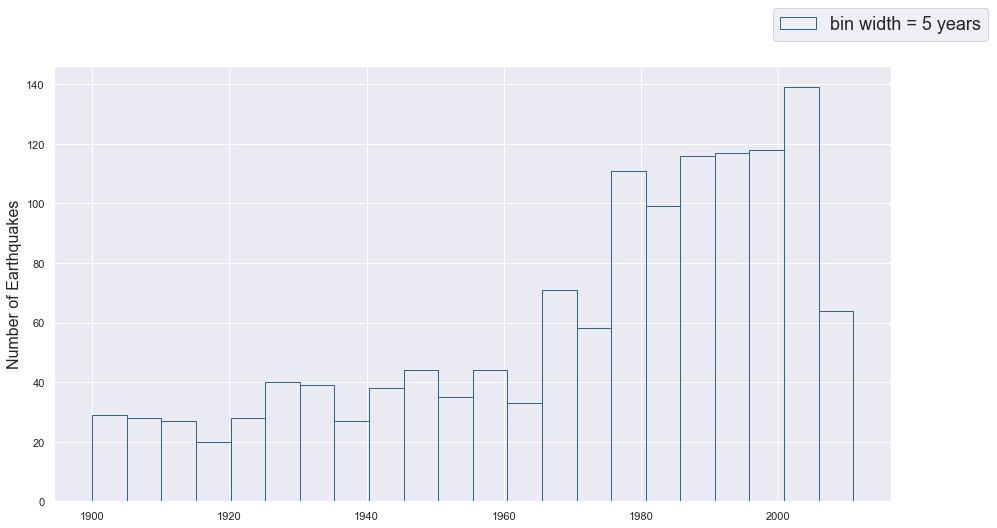

In [172]:
fig, ax = plt.subplots(figsize=(15,8))
#sns.distplot(df.Year,kde=False,bins=int((max(df.Year)-min(df.Year))/5.), hist_kws={"histtype": "bar", \
#    "linewidth": 3,"alpha": 0.8, "edgecolor": "#31668a", "facecolor": "None", "label":"bin width = 5 years"})
df.Year.plot(ax=ax, kind='hist',histtype='bar',bins=int((max(df.Year)-min(df.Year))/5.),label='bin width = 5 years',edgecolor='#31668a',facecolor='None')
ax.set_ylabel('Number of Earthquakes',fontsize=16)
fig.legend(fontsize=18);

<Figure size 1080x576 with 0 Axes>

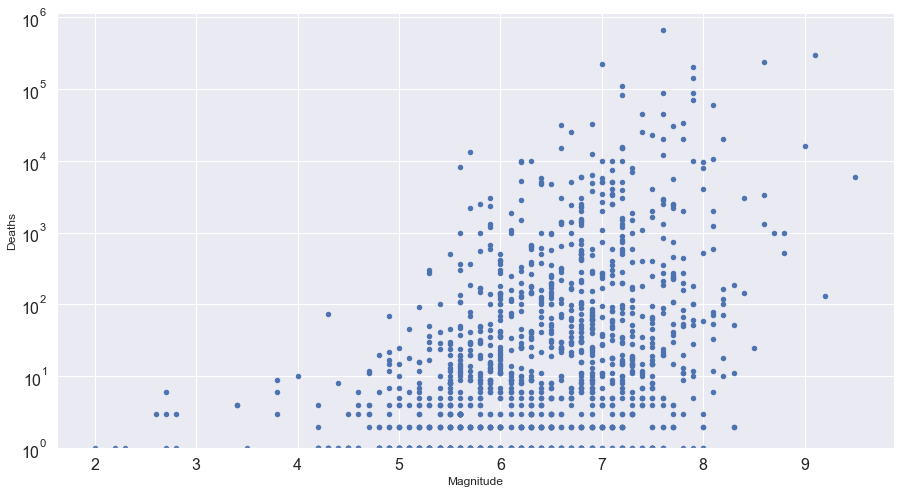

In [173]:
plt.figure(figsize=(15,8));
df.plot(kind='scatter',x='Magnitude',y='Deaths',figsize=(15,8),fontsize=16, marker='o');
plt.semilogy();
plt.ylim(bottom=1);
#plt.locator_params(axis='x', numticks=4)
#plt.xticks(rotation=70);

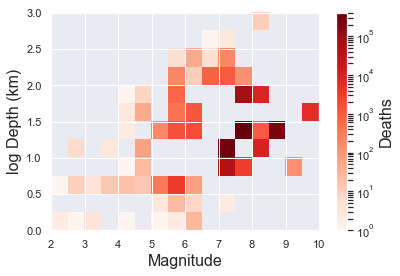

In [174]:
xedges = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
#yedges = [0,50,100,150,200,250,300,350,400,450,500,550,600,650]
yedges = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3] #50,100,150,200,250,300,350,400,450,500,550,600,650]
from matplotlib.colors import LogNorm
plt.hist2d(df.Magnitude, np.log10(df['Depth (km)']), weights=df.Deaths, bins=[xedges,yedges], cmap='Reds', norm=LogNorm())
plt.xlabel('Magnitude',fontsize=16)
plt.ylabel('log Depth (km)',fontsize=16)
plt.colorbar().set_label(label='Deaths',size=16)
plt.show()

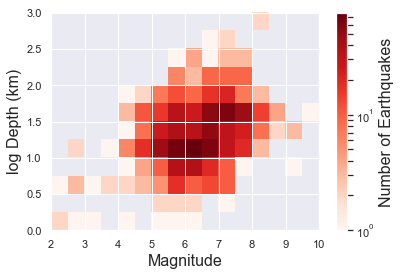

In [175]:
xedges = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
yedges = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3] #50,100,150,200,250,300,350,400,450,500,550,600,650]
from matplotlib.colors import LogNorm
plt.hist2d(df.Magnitude, np.log10(df['Depth (km)']), bins=[xedges,yedges], cmap='Reds', norm=LogNorm())
plt.xlabel('Magnitude',fontsize=16)
plt.ylabel('log Depth (km)',fontsize=16)
plt.colorbar().set_label(label='Number of Earthquakes',size=16)
plt.show()

In [176]:
df['Secondary Effects'].value_counts()

L         163
T         144
T,L        26
L,Lq       10
F           9
T,F         5
T,L,Lq      4
Lq          3
T,LF        2
T,Lq        2
L,F,Lq      1
L,F         1
Name: Secondary Effects, dtype: int64

In [177]:
df['Secondary Effects'] = df['Secondary Effects'].astype(str).str.replace('Lq','Q')
tsunami = df[df['Secondary Effects'].astype(str).str.contains('T')]
fire = df[df['Secondary Effects'].astype(str).str.contains('F')]
landslide = df[df['Secondary Effects'].astype(str).str.contains('L')]
liquefaction = df[df['Secondary Effects'].astype(str).str.contains('Q')]
liquefaction['Secondary Effects'].value_counts()

L,Q      10
T,L,Q     4
Q         3
T,Q       2
L,F,Q     1
Name: Secondary Effects, dtype: int64

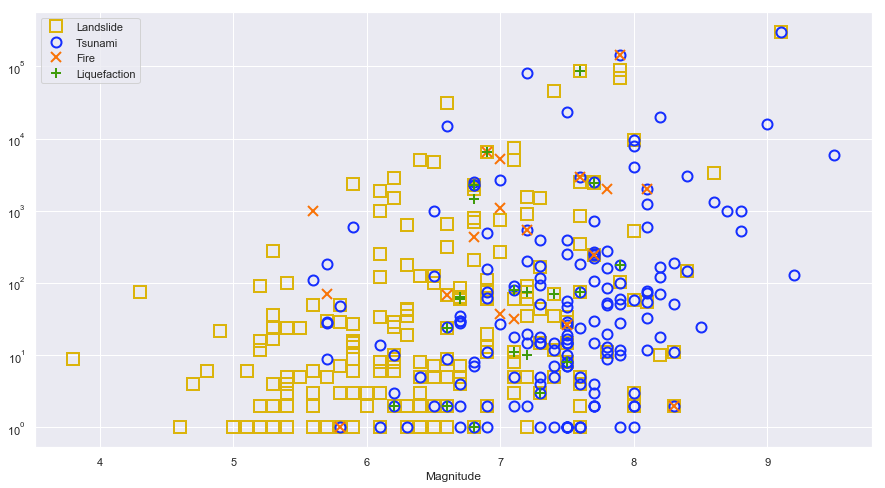

In [178]:
fig, ax = plt.subplots(figsize=(15,8))
landslide.plot(ax=ax, x='Magnitude',y='Deaths',label='Landslide',marker='s',ms=12,markerfacecolor='None',markeredgecolor='#dbb40c',markeredgewidth=2,linestyle='None',figsize=(15,8))
#ax2 = ax.twinx()
tsunami.plot(ax=ax,x='Magnitude',y='Deaths',label='Tsunami',marker='o',ms=10,markerfacecolor='None',markeredgecolor='#152eff',markeredgewidth=2,linestyle='None')
#ax3 = ax.twinx()
fire.plot(ax=ax,x='Magnitude',y='Deaths',label='Fire',marker='x',ms=10,color='#f97306',markeredgewidth=2,linestyle='None')
#ax4 = ax.twinx()
liquefaction.plot(ax=ax, x='Magnitude',label='Liquefaction',y='Deaths',marker='+',ms=10,color='#3f9b0b',markeredgewidth=2,linestyle='None')
plt.legend()
ax.semilogy()
plt.show()

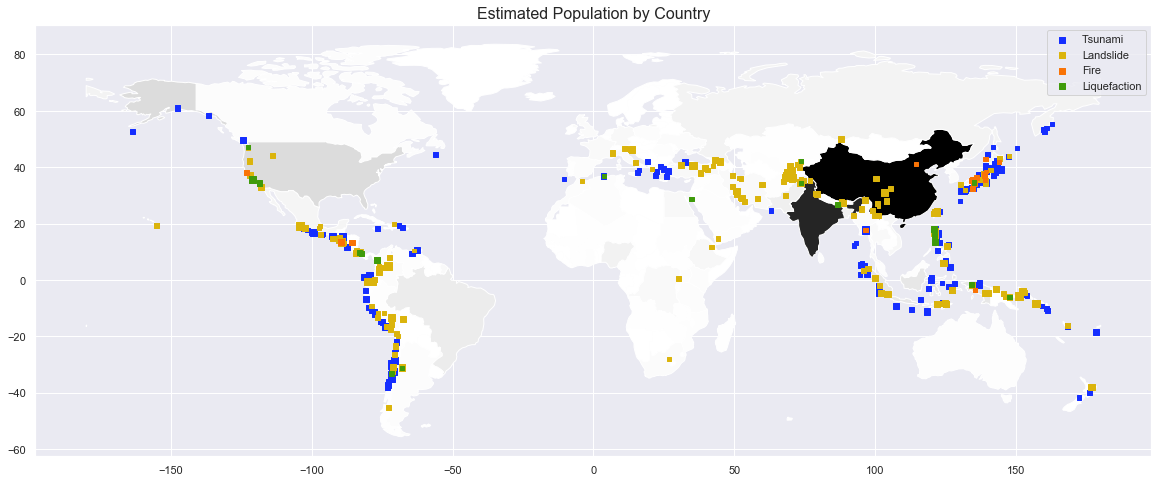

In [179]:
landslideGEO = [Point(xy) for xy in zip(landslide.Long.astype('float64'), landslide.Lat.astype('float64'))]
fireGEO = [Point(xy) for xy in zip(fire.Long.astype('float64'), fire.Lat.astype('float64'))]
tsunamiGEO = [Point(xy) for xy in zip(tsunami.Long.astype('float64'), tsunami.Lat.astype('float64'))]
liquefactionGEO = [Point(xy) for xy in zip(liquefaction.Long.astype('float64'), liquefaction.Lat.astype('float64'))]

landslide = landslide.drop(['Long', 'Lat'], axis=1)
fire = fire.drop(['Long', 'Lat'], axis=1)
tsunami = tsunami.drop(['Long', 'Lat'], axis=1)
liquefaction = liquefaction.drop(['Long', 'Lat'], axis=1)

crs = {'init': 'epsg:4326'}
landslideGDF = GeoDataFrame(landslide, crs=crs, geometry=landslideGEO)
fireGDF = GeoDataFrame(fire, crs=crs, geometry=fireGEO)
tsunamiGDF = GeoDataFrame(tsunami, crs=crs, geometry=tsunamiGEO)
liquefactionGDF = GeoDataFrame(liquefaction, crs=crs, geometry=liquefactionGEO)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
ax = world.plot(figsize=(20,15),column='pop_est',cmap='Greys');

tsunamiGDF.plot(ax=ax,marker='s',color='#152eff',markersize=1.6**df.Magnitude.astype('float64'), label='Tsunami');
landslideGDF.plot(ax=ax,marker='s',color='#dbb40c',markersize=1.6**df.Magnitude.astype('float64'),label='Landslide');
fireGDF.plot(ax=ax,marker='s',color='#f97306',markersize=1.6**df.Magnitude.astype('float64'),label='Fire');
liquefactionGDF.plot(ax=ax,marker='s',color='#3f9b0b',markersize=1.6**df.Magnitude.astype('float64'), label='Liquefaction');
ax.set_title('Estimated Population by Country',fontsize=16);
ax.legend();

In [180]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,gdp_per_cap
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",0.000784
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,0.008618
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",0.005993
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",0.038408
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,0.014027


#### The 10 countries with the most earthquakes from 1900 to 2011 are...

In [181]:
df.Country.value_counts().nlargest(10)

China        162
Indonesia     94
Turkey        94
Iran          91
Japan         81
Peru          54
Taiwan        48
Mexico        46
Greece        44
Chile         43
Name: Country, dtype: int64

#### The countries with the 10 deadliest earthquakes from 1900 to 2011 are...

In [182]:
df.nlargest(10,'Deaths').Country.value_counts()

China           4
Pakistan        1
Haiti           1
Japan           1
Indonesia       1
Italy           1
Turkmenistan    1
Name: Country, dtype: int64

In [183]:
#world.rename(index=str,columns={'name':'Country'},inplace=True)
#newdf = pd.merge(df, world, how='outer')
#newdf.head(10)
#for row in df.iterrows():
#    df[row,'GDP Per Cap'] = world['gdp_per_cap'].where(world['name'].str.contains(df[row,'Country']))
#world.columns()

In [184]:
#ax = sns.swarmplot(x='Secondary Effects', y='Deaths', data=df[df['Secondary Effects'] != 'nan'])
#ax.semilogy()

In [193]:
over6 = df[df.Magnitude > 6.0]

In [194]:
over6since2000 = over6[over6.Year >= 2000]

In [195]:
over6since2000 = over6since2000[over6since2000.Deaths.notna()][['TimeUTC','Country','Lat','Long','Depth (km)','Magnitude','Secondary Effects', 'Year', 'Deaths']]

In [196]:
over6since2000.head()

,TimeUTC,Country,Lat,Long,Depth (km),Magnitude,Secondary Effects,Year,Deaths
1102,2000-05-04 04:21,Indonesia,-1.140,123.522,26.0,7.5,T,2000,46.0
1104,2000-05-12 18:43,Argentina,-23.754,-66.777,225.0,7.2,nan,2000,1.0
1106,2000-06-04 16:28,Indonesia,-4.760,102.031,33.8,7.9,L,2000,103.0
1109,2000-06-07 23:45,Indonesia,-4.651,101.848,32.0,6.7,nan,2000,1.0
1110,2000-06-10 18:23,Taiwan,23.868,121.181,19.0,6.4,L,2000,2.0


In [212]:
gdp = pd.read_csv('data/WorldBankPercentGrowthGDP.csv')
gdp.loc['Country Name'].str.contains('Iran') = 'Iran'

SyntaxError: can't assign to function call (<ipython-input-212-bfcd5d0b8a99>, line 2)

In [211]:
over6since2000['GDP'] = ""
for index, row in over6since2000.iterrows():
    if not row.Country in ['Taiwan','Martinique']:
        print(row.Country,row.Year)
        gdprow = gdp['Country Name'].loc[gdp['Country Name']==row.Country].index[0]
        gdpcol = gdp.filter(regex=str(row.Year)).columns[0]
        print(row.Country,row.Year,gdp.loc[gdprow,gdpcol])
        over6since2000.loc[index,'GDP'] = gdp.loc[gdprow,gdpcol]

Indonesia 2000
Indonesia 2000 4.9200677470169
Argentina 2000
Argentina 2000 -0.78899893905691
Indonesia 2000
Indonesia 2000 4.9200677470169
Indonesia 2000
Indonesia 2000 4.9200677470169
Japan 2000
Japan 2000 2.7796328252636
Afghanistan 2000
Afghanistan 2000 ..
Tanzania 2000
Tanzania 2000 4.93384662711458
Colombia 2000
Colombia 2000 4.41999299958138
Papua New Guinea 2000
Papua New Guinea 2000 -2.49484199260023
Azerbaijan 2000
Azerbaijan 2000 11.0999992535406
Turkmenistan 2000
Turkmenistan 2000 5.46906413252853
El Salvador 2001
El Salvador 2001 0.877318892023496
India 2001
India 2001 4.82396626398834
El Salvador 2001
El Salvador 2001 0.877318892023496
United States 2001
United States 2001 0.975981833932124
Japan 2001
Japan 2001 0.406335903197757
Peru 2001
Peru 2001 0.617892325624297
Peru 2001
Peru 2001 0.617892325624297
Chile 2001
Chile 2001 3.3030473125087
Papua New Guinea 2002
Papua New Guinea 2002 -0.158900533082658
Greece 2002
Greece 2002 3.92287184229497
Turkey 2002
Turkey 2002 6.43

IndexError: index 0 is out of bounds for axis 0 with size 0

In [208]:
over6since2000

,TimeUTC,Country,Lat,Long,Depth (km),Magnitude,Secondary Effects,Year,Deaths,GDP
1102,2000-05-04 04:21,Indonesia,-1.1400,123.5220,26.0,7.5,T,2000,46.0,4.9200677470169
1104,2000-05-12 18:43,Argentina,-23.7540,-66.7770,225.0,7.2,nan,2000,1.0,-0.78899893905691
1106,2000-06-04 16:28,Indonesia,-4.7600,102.0310,33.8,7.9,L,2000,103.0,4.9200677470169
1109,2000-06-07 23:45,Indonesia,-4.6510,101.8480,32.0,6.7,nan,2000,1.0,
1110,2000-06-10 18:23,Taiwan,23.8680,121.1810,19.0,6.4,L,2000,2.0,
1111,2000-07-01 07:01,Japan,34.2220,139.1710,12.5,6.1,"T,L",2000,1.0,
1114,2000-07-17 22:53,Afghanistan,36.2450,70.9430,135.0,6.3,nan,2000,2.0,
1117,2000-10-02 02:25,Tanzania,-7.9650,30.8060,34.0,6.4,nan,2000,1.0,
1118,2000-11-08 06:59,Colombia,7.0910,-77.8110,17.0,6.5,nan,2000,2.0,
1120,2000-11-16 04:54,Papua New Guinea,-3.9960,152.2680,27.6,8.0,"T,L",2000,2.0,-2.49484199260023
